In [5]:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx



from SALib.analyze import sobol


In [16]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.1
3.1


In [8]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time



In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
# our objective= minimize total costs

''''
2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties (choose this)
4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs (choose this)
'''
dike_model, planning_steps = get_model_for_problem_formulation(2)


In [11]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# location dependent parameters
# Bmax = final breach width (absolute)
# pfail = dike failure probability
# Brate = Breach width model (relative) /day
# ID_flood wafe shape

#discount rate Multiple Decision Points: The dike_model likely involves multiple decision points or stages over time. Each discount rate parameter can correspond to a specific decision point or phase in the model. For example, discount rate 0 may be associated with immediate costs and benefits, discount rate 1 with short-term impacts, and discount rate 2 with long-term consequences. This allows for evaluating the sensitivity of decisions and outcomes to varying discount rates at different stages.


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [13]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary


# Each lever has a specific name and range of values denoted by the indexes. Let's break down the levers and their indexes: The indexes indicate the available options or levels for each lever. For example, the '0_RfR 0' lever has two options: 0 and 1. Similarly, the 'A.1_DikeIncrease 0' lever has eleven options from 0 to 10. The specific index value chosen for each lever determines the level or intensity of the intervention applied during the model simulation.
#Rfr: different project:switch on 1 off 0
#Dike_increase: different intensity in dike increase 0 to 10

for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [14]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x000001D416ADE480>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [23]:
# running the model through EMA workbench
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200, policies=4)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 200 scenarios * 4 policies * 1 model(s) = 800 experiments
100%|████████████████████████████████████████| 800/800 [02:32<00:00,  5.24it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())


# Location dependent
# total costs
# expected number ot deaths
# RfR Total Costs
# Expected Evacuation costs



dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


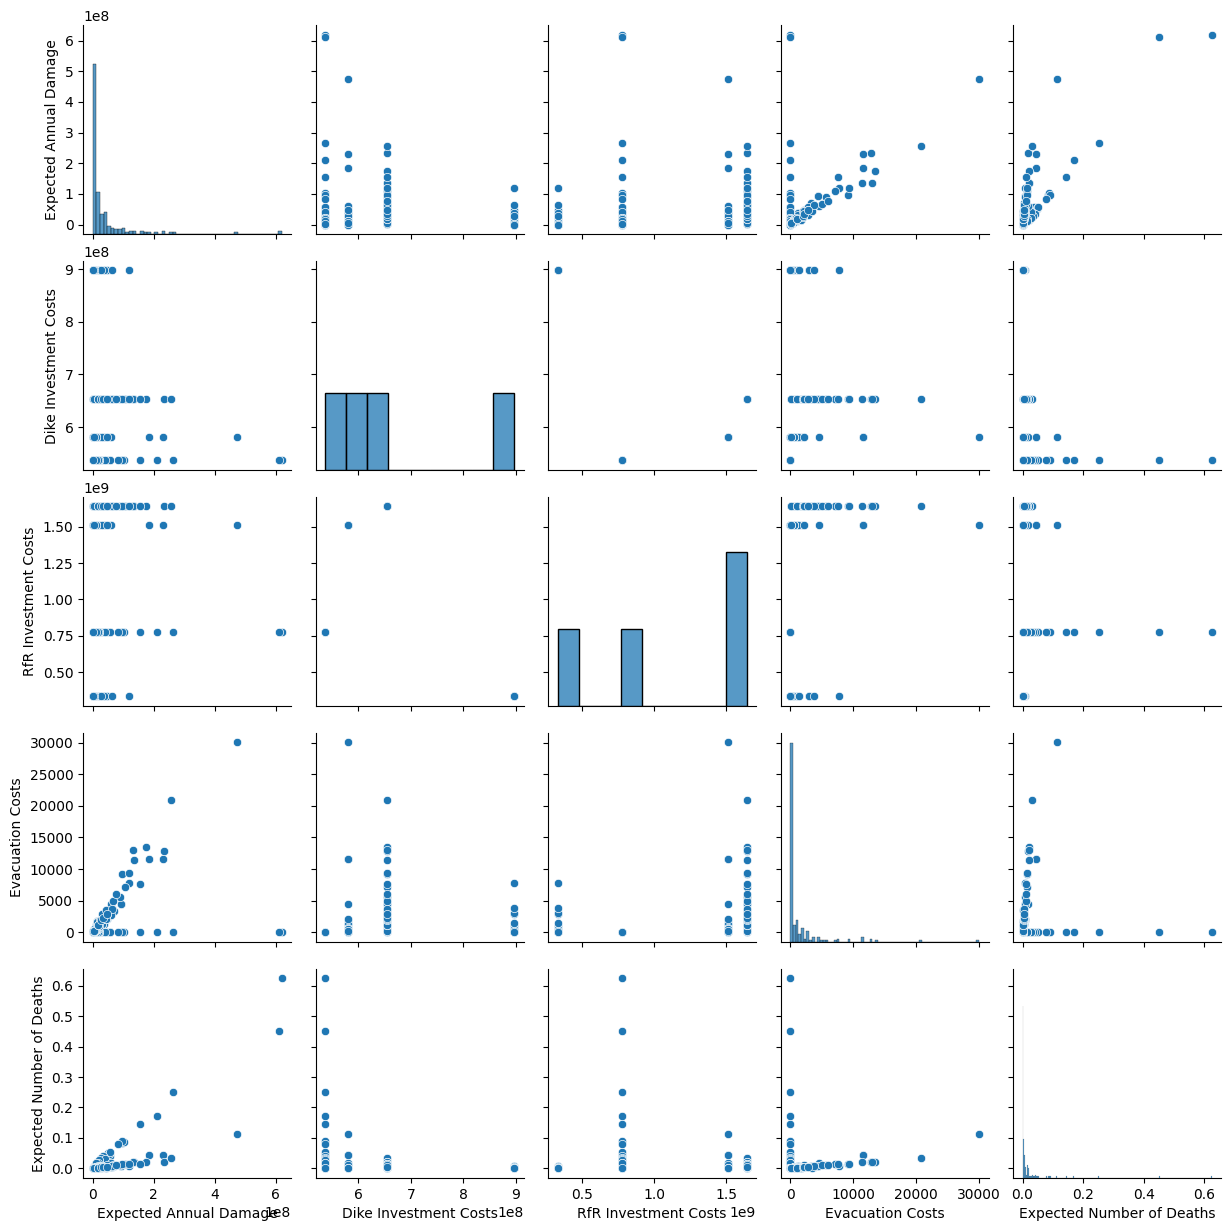

<Figure size 640x480 with 0 Axes>

In [24]:
# only works because we have scalar outcomes
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()
plt.savefig('outcomes vs outcome')

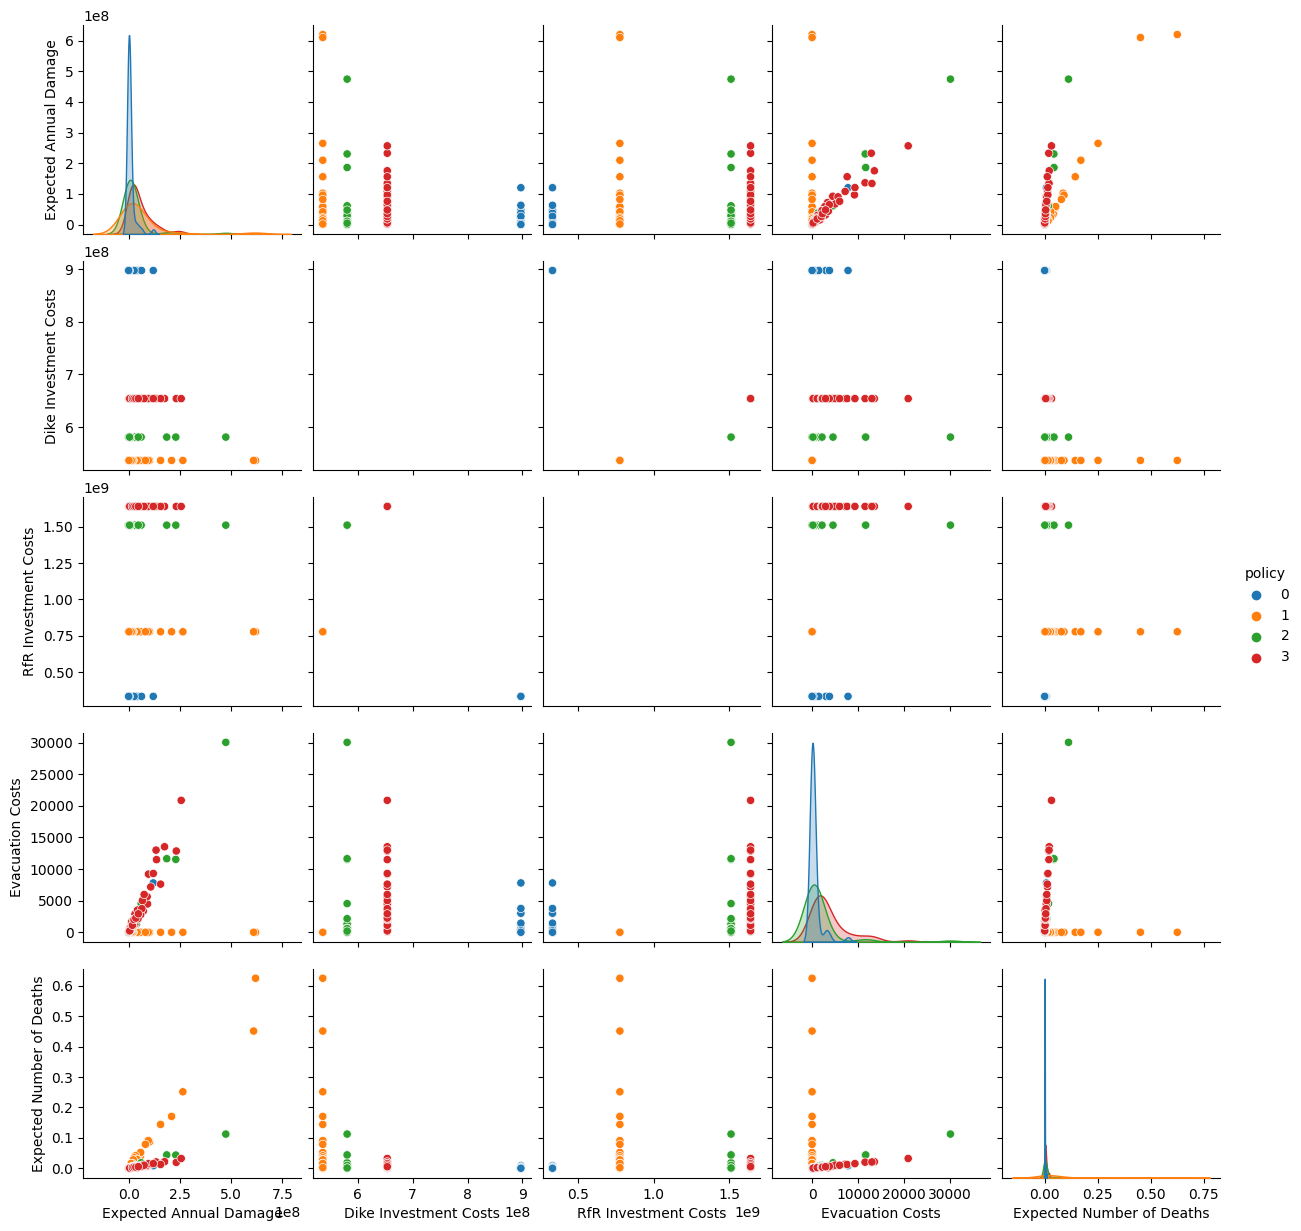

In [25]:
# plot here outcome vs. outcome dependend on policy

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()



In [36]:
experiments_df = pd.DataFrame.from_dict(experiments)

#apply filter
experiments_df[experiments_df['policy']==0]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,92,224.612729,10.0,0.892914,219.575632,10.0,0.724529,133.080086,1.5,0.824714,...,3,1,3,9,6,1,2,4,0,dikesnet
1,17,210.448906,1.0,0.941986,272.679476,1.0,0.868107,157.521177,10.0,0.630026,...,3,1,3,9,6,1,2,5,0,dikesnet
2,51,125.632944,1.5,0.047664,310.129416,1.5,0.167101,170.860763,1.0,0.975744,...,3,1,3,9,6,1,2,6,0,dikesnet
3,108,287.060584,10.0,0.797343,287.641000,1.0,0.106409,83.022454,1.5,0.933311,...,3,1,3,9,6,1,2,7,0,dikesnet
4,69,116.799191,10.0,0.139402,74.397755,10.0,0.990599,122.861892,10.0,0.211836,...,3,1,3,9,6,1,2,8,0,dikesnet
5,125,346.128087,10.0,0.984765,65.547317,10.0,0.202934,36.961025,1.0,0.718638,...,3,1,3,9,6,1,2,9,0,dikesnet
6,14,194.706868,1.5,0.937183,343.550337,1.0,0.914920,241.453179,1.5,0.943952,...,3,1,3,9,6,1,2,10,0,dikesnet
7,80,75.906989,10.0,0.772819,54.458276,1.5,0.184158,219.830867,10.0,0.099613,...,3,1,3,9,6,1,2,11,0,dikesnet
8,57,284.768959,1.0,0.739939,141.110195,10.0,0.891493,264.562950,10.0,0.101824,...,3,1,3,9,6,1,2,12,0,dikesnet
9,71,30.214269,10.0,0.090370,133.312151,1.0,0.759079,228.085759,1.0,0.690967,...,3,1,3,9,6,1,2,13,0,dikesnet


In [38]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations

# BAU = Rfr (x,t) ; Dike increase (x,t) =0
# Dike heightening scenario RFR=0 Dike heigth = 5
#


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "Dike Increase medium",
        **dict(get_do_nothing_dict(),
                **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':5,
                  'A.1_DikeIncrease 2':5,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':5,
                  'A.2_DikeIncrease 2':5,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':5,
                  'A.3_DikeIncrease 2':5,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':5,
                  'A.4_DikeIncrease 2':5,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':5,
                  'A.5_DikeIncrease 2':5})
    ),
    Policy(
        "Dike Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':10,
                  'A.1_DikeIncrease 2':10,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':10,
                  'A.2_DikeIncrease 2':10,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':10,
                  'A.3_DikeIncrease 2':10,
                  'A.4_DikeIncrease 0':10,
                  'A.4_DikeIncrease 1':10,
                  'A.4_DikeIncrease 2':10,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':10,
                  'A.5_DikeIncrease 2':10}
        )
    ),
]

In [39]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
100%|████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [51]:
experiments, outcomes = results

In [52]:
# only works because we have scalar outcomes
pd.DataFrame(outcomes)

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,4.909537e+08,0,0.0,0.0,0.426442
1,1.082556e+09,0,0.0,0.0,1.205835
2,2.178425e+09,0,0.0,0.0,1.927490
3,2.832156e+09,0,0.0,0.0,1.828155
4,2.269071e+09,0,0.0,0.0,3.902168
...,...,...,...,...,...
295,0.000000e+00,1292588182,0.0,0.0,0.000000
296,0.000000e+00,1292588182,0.0,0.0,0.000000
297,0.000000e+00,1292588182,0.0,0.0,0.000000
298,2.113247e+05,1292588182,0.0,0.0,0.000261


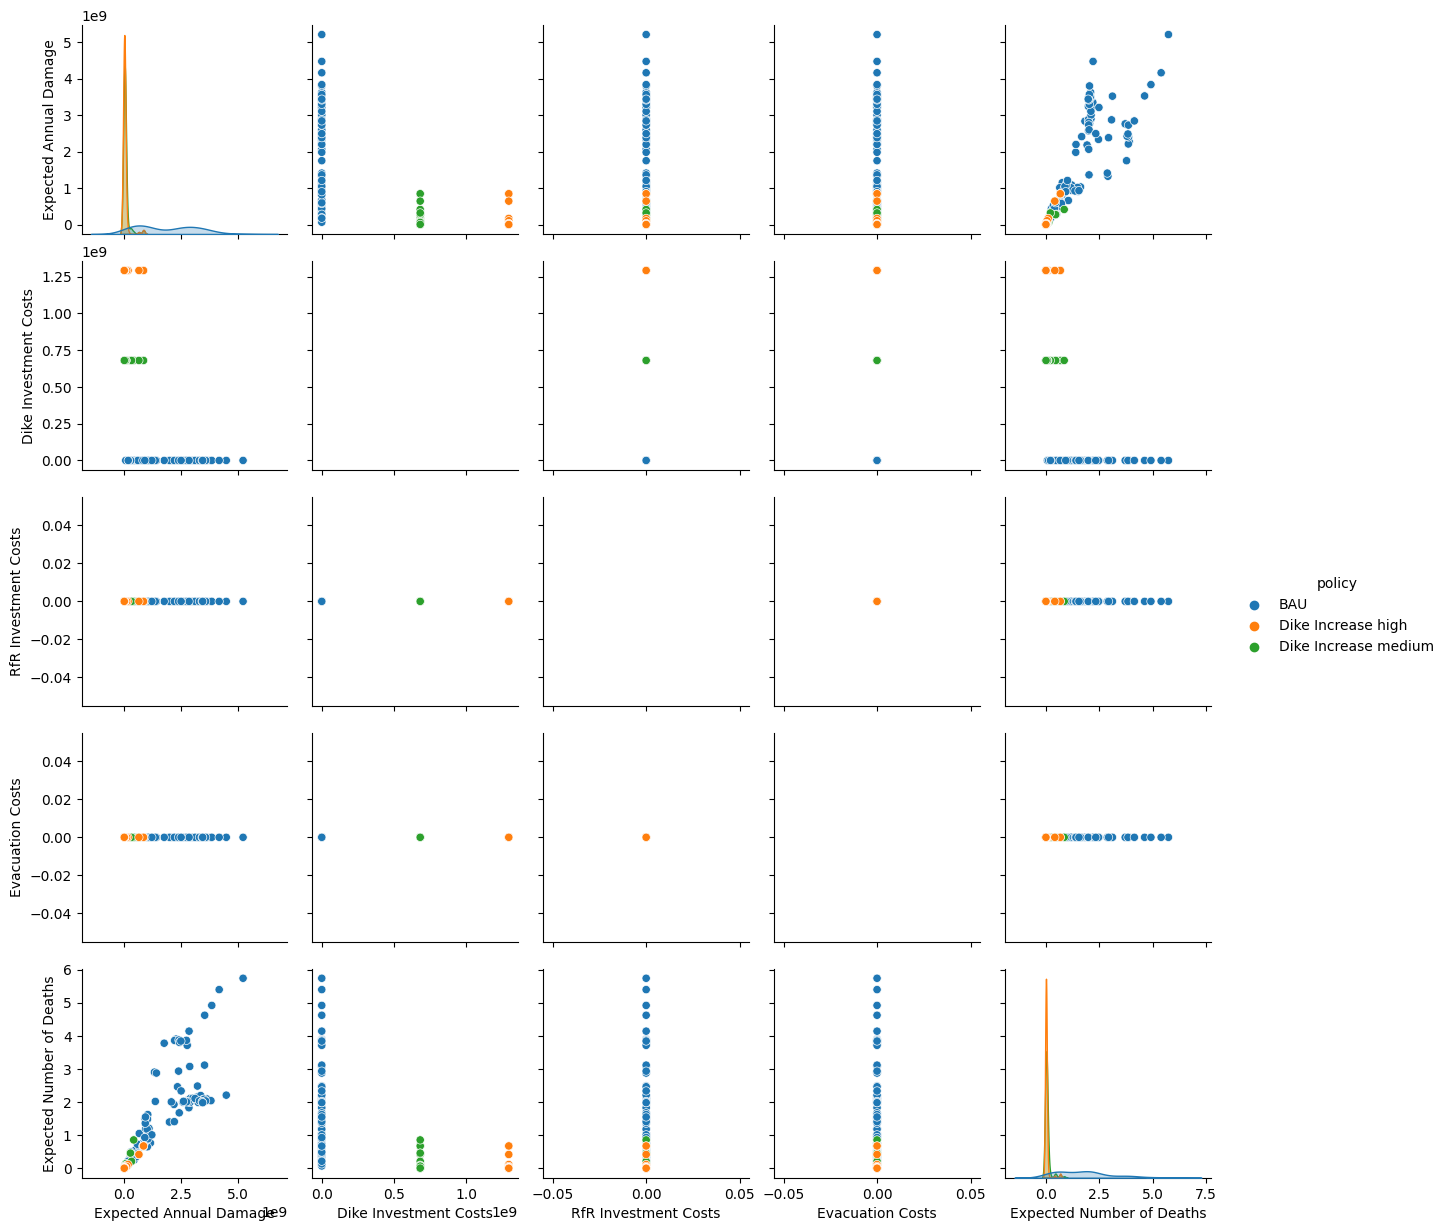

<Figure size 640x480 with 0 Axes>

In [53]:
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()
plt.savefig('outcome vs outcome first experiments')




In [49]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

problem = get_SALib_problem(uncertainties)
print(problem)


{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [54]:
n_exp = 1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(dike_model, scenarios=n_exp,
                                                            uncertainty_sampling=Samplers.SOBOL)


#outcomes_Si = outcomes_sobol['Expected Annual Damage']

#Si = sobol.analyze(problem, outcomes_Si, calc_second_order=True, print_to_console=True)




[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] terminating pool


TypeError: BaseEvaluator.perform_experiments() got multiple values for argument 'scenarios'

In [1]:
##hello flo